In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.fft import fft2, ifft2
from sklearn.linear_model import LinearRegression
from scipy import interpolate, fftpack
from scipy.interpolate import griddata
import cv2
from numpy.linalg import lstsq


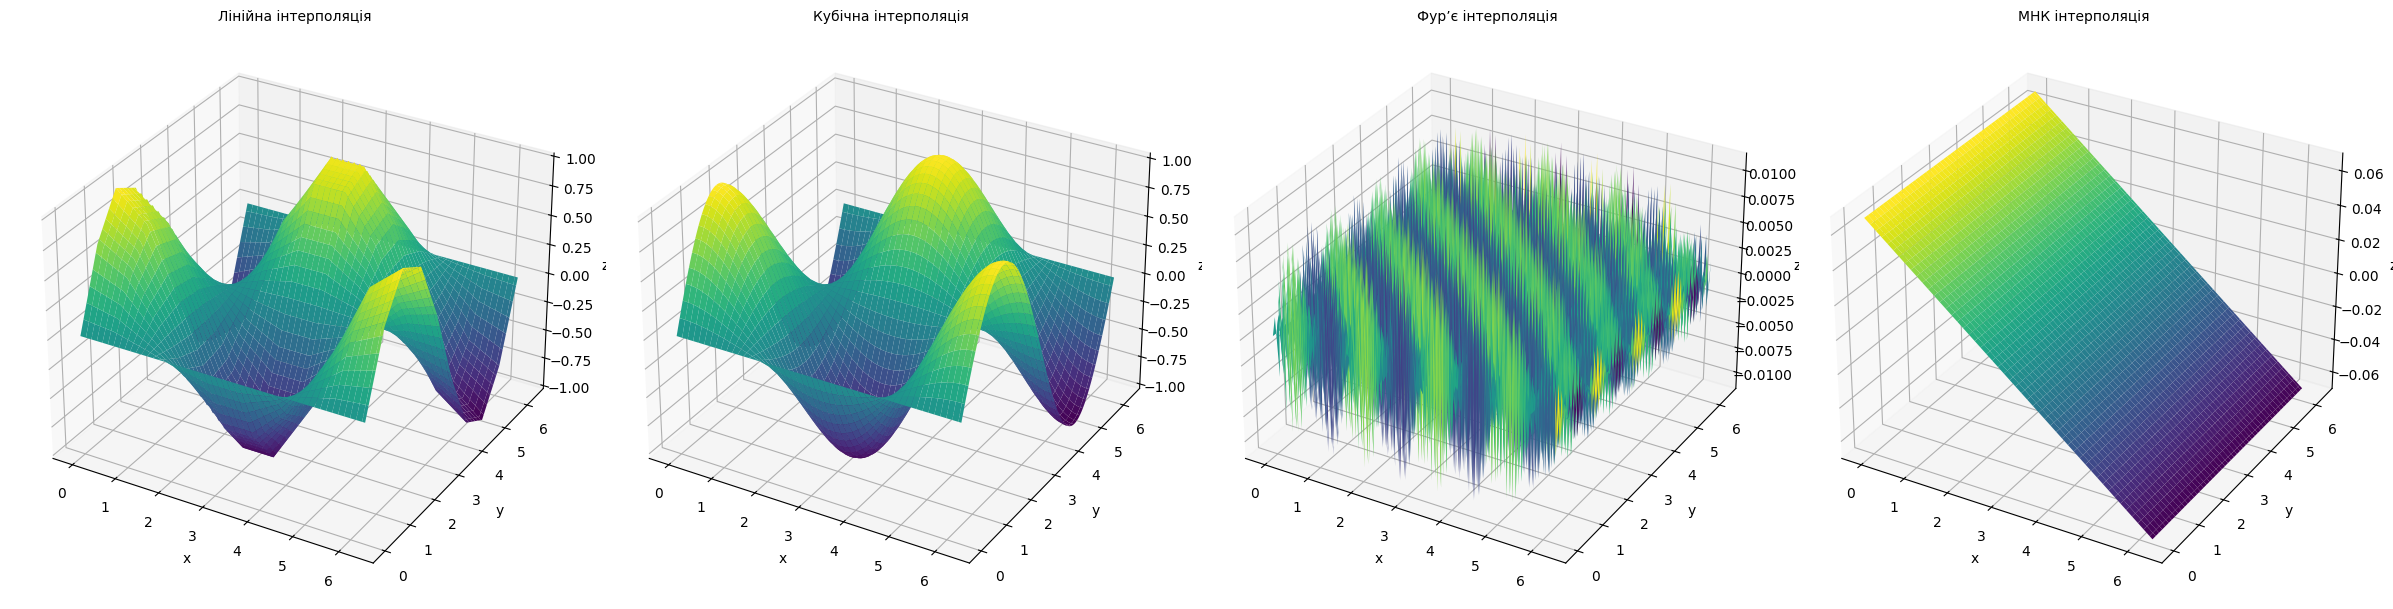

In [43]:
x = np.linspace(0, 2*np.pi, 10)
y = np.linspace(0, 2*np.pi, 10)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) * np.cos(Y)


x_new = np.linspace(0, 2*np.pi, 100)
y_new = np.linspace(0, 2*np.pi, 100)
Xn, Yn = np.meshgrid(x_new, y_new)
new_points = np.c_[Xn.ravel(), Yn.ravel()]

# Лінійна інтерполяція 
Z_lin = RegularGridInterpolator((x, y), Z, method='linear')(new_points).reshape(Xn.shape)

# Кубічна інтерполяція 
Z_cub = RegularGridInterpolator((x, y), Z, method='cubic')(new_points).reshape(Xn.shape)

# Інтерполяція в Фур’є-просторі
Z_fft = fft2(Z)
pad_x = (100 - Z.shape[0]) // 2
pad_y = (100 - Z.shape[1]) // 2
Z_fft_pad = np.pad(Z_fft, ((pad_x, pad_x), (pad_y, pad_y)), mode='constant')
Z_fourier = np.real(ifft2(Z_fft_pad))

# Інтерполяція за методом найменших квадратів
x_flat, y_flat, z_flat = X.ravel(), Y.ravel(), Z.ravel()
features = np.c_[x_flat, y_flat, x_flat**2, y_flat**2, x_flat*y_flat]
model = LinearRegression().fit(features, z_flat)

features_new = np.c_[
    Xn.ravel(), Yn.ravel(),
    Xn.ravel()**2, Yn.ravel()**2,
    Xn.ravel() * Yn.ravel()
]
Z_mnk = model.predict(features_new).reshape(Xn.shape)


methods = ["Лінійна", "Кубічна", "Фур’є", "МНК"]
results = [Z_lin, Z_cub, Z_fourier, Z_mnk]

fig = plt.figure(figsize=(24, 6))
for i, (title, Z_interp) in enumerate(zip(methods, results), 1):
    ax = fig.add_subplot(1, 4, i, projection='3d')
    ax.plot_surface(Xn, Yn, Z_interp, cmap='viridis')
    ax.set_title(f"{title} інтерполяція", fontsize=10)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

plt.tight_layout()
plt.show()


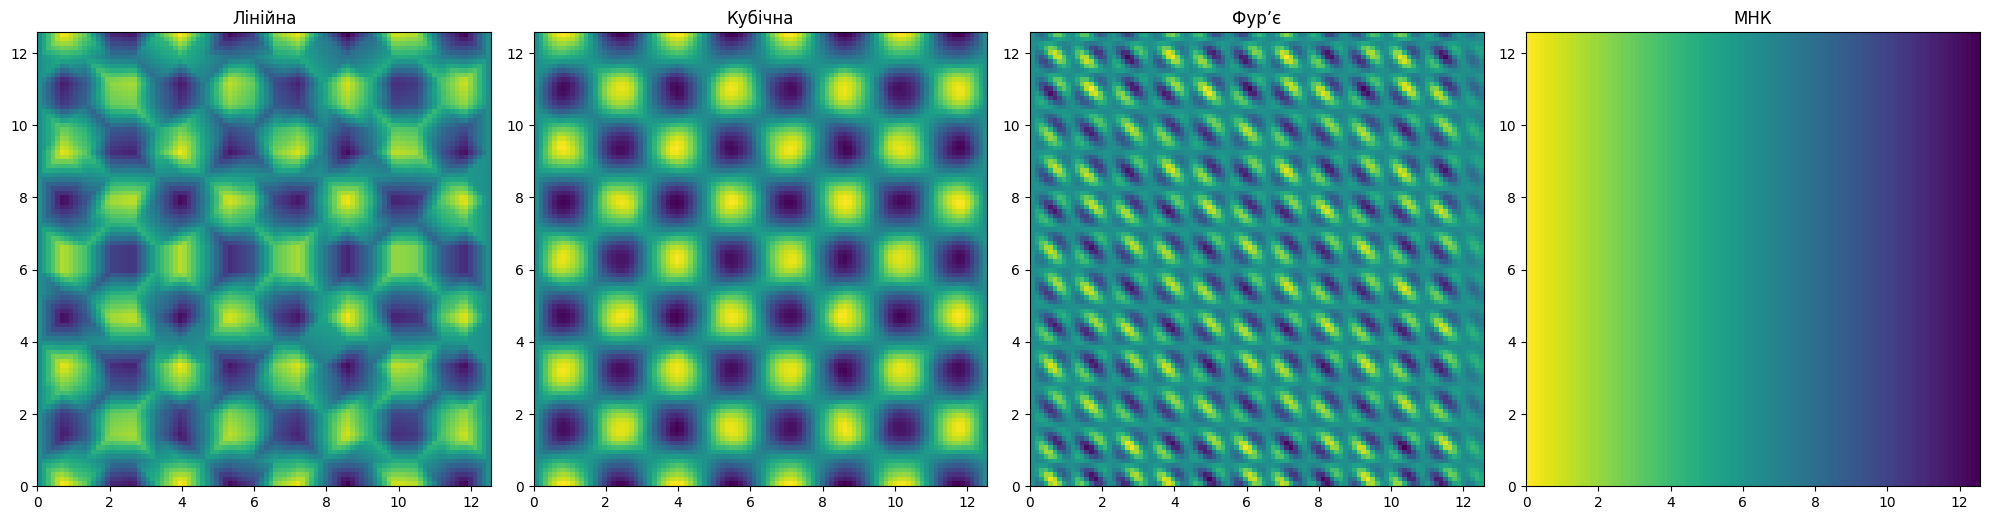

In [44]:
def f(x, y):
    return np.sin(2*x) * np.cos(2*y)

x = np.linspace(0, 4*np.pi, 20)
y = np.linspace(0, 4*np.pi, 20)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

x_new = np.linspace(0, 4*np.pi, 100)
y_new = np.linspace(0, 4*np.pi, 100)
Xn, Yn = np.meshgrid(x_new, y_new)

points = np.c_[X.ravel(), Y.ravel()]
values = Z.ravel()
grid_points = (Xn, Yn)

# Лінійна інтерполяція 
Z_lin = griddata(points, values, grid_points, method='linear')

# Кубічна інтерполяція 
Z_cub = griddata(points, values, grid_points, method='cubic')

# Фур’є-інтерполяція
Z_fft = fftpack.fft2(Z)
Z_fft_up = np.zeros((100, 100), dtype=complex)
Z_fft_up[:20, :20] = Z_fft
Z_fourier = np.real(fftpack.ifft2(Z_fft_up))

# МНК
x_flat, y_flat = X.ravel(), Y.ravel()
features = np.c_[x_flat, y_flat, x_flat*y_flat, x_flat**2, y_flat**2]

model = LinearRegression().fit(features, Z.ravel())

x_new_flat = Xn.ravel()
y_new_flat = Yn.ravel()
features_new = np.c_[x_new_flat, y_new_flat, x_new_flat*y_new_flat, x_new_flat**2, y_new_flat**2]
Z_mnk = model.predict(features_new).reshape(Xn.shape)

titles = ["Лінійна", "Кубічна", "Фур’є", "МНК"]
results = [Z_lin, Z_cub, Z_fourier, Z_mnk]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (title, Z_img) in enumerate(zip(titles, results)):
    axs[i].imshow(Z_img, extent=(0, 4*np.pi, 0, 4*np.pi), origin='lower', cmap='viridis')
    axs[i].set_title(title)
plt.tight_layout()
plt.show()


Лінійна інтерполяція

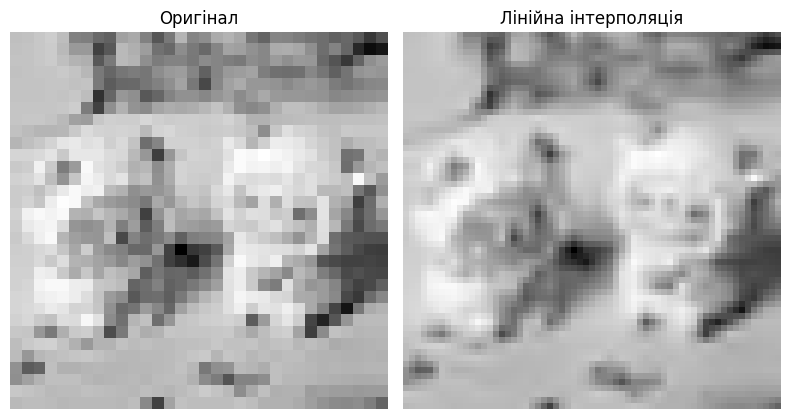

In [45]:
def enlarge_image(image: np.ndarray, scale: int = 2, fill: int | float = 0) -> np.ndarray:
    h, w = image.shape
    new_h = (h - 1) * scale + 1
    new_w = (w - 1) * scale + 1
    enlarged = np.full((new_h, new_w), fill, dtype=np.float32)
    enlarged[::scale, ::scale] = image
    return enlarged

img = cv2.imread("small32.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)

# Збільшення зображення з нулями 
scale = 2
img_large = enlarge_image(img, scale)

# Інтерполяція
h, w = img.shape
new_h, new_w = img_large.shape

x = np.arange(h)
y = np.arange(w)
x_new = np.linspace(0, h - 1, new_h)
y_new = np.linspace(0, w - 1, new_w)

interp = RegularGridInterpolator((x, y), img, method='linear', bounds_error=False, fill_value=0)

grid_x, grid_y = np.meshgrid(x_new, y_new, indexing='ij')
interpolated = interp(np.stack([grid_x, grid_y], axis=-1))

# Заповнення пропущених значень
img_large[img_large == 0] = interpolated[img_large == 0]


plt.figure(figsize=(8, 45))
plt.subplot(1, 2, 1)
plt.title("Оригінал")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Лінійна інтерполяція")
plt.imshow(np.clip(img_large, 0, 255), cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


Поліноміальна інтерполяція(+метод найменших квадратів)

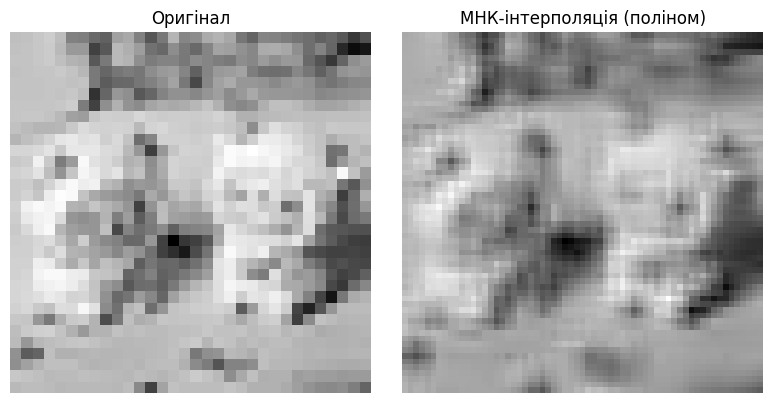

In [46]:
def enlarge_image(img: np.ndarray, scale: int = 2, fill: int | float = 0) -> np.ndarray:
    h, w = img.shape
    new_h = (h - 1) * scale + 1
    new_w = (w - 1) * scale + 1
    enlarged = np.full((new_h, new_w), fill, dtype=np.float32)
    enlarged[::scale, ::scale] = img
    return enlarged

def polynomial_features(x, y, degree=2):
    return np.stack([(x**i) * (y**j) for i in range(degree + 1) for j in range(degree + 1 - i)], axis=1)

def interpolate_patch_mnk(x, y, z, x_new, y_new, degree=2):
    X = polynomial_features(x.ravel(), y.ravel(), degree)
    coeffs, *_ = lstsq(X, z.ravel(), rcond=None)
    X_new = polynomial_features(x_new.ravel(), y_new.ravel(), degree)
    return X_new @ coeffs


img = cv2.imread("small32.png", cv2.IMREAD_GRAYSCALE).astype(np.float32)
scale = 2
img_large = enlarge_image(img, scale)

# Інтерполяція по частинах
patch_size = 4
h, w = img.shape

for i in range(h - patch_size + 1):
    for j in range(w - patch_size + 1):
        patch = img[i:i + patch_size, j:j + patch_size]
        if patch.shape != (patch_size, patch_size):
            continue

        x, y = np.meshgrid(np.arange(patch_size), np.arange(patch_size), indexing='ij')

        x_new = np.linspace(0, patch_size - 1, (patch_size - 1) * scale + 1)
        y_new = np.linspace(0, patch_size - 1, (patch_size - 1) * scale + 1)
        x_grid, y_grid = np.meshgrid(x_new, y_new, indexing='ij')

        z_interp = interpolate_patch_mnk(x, y, patch, x_grid, y_grid).reshape(x_grid.shape)

        x_start = i * scale
        y_start = j * scale
        x_end = x_start + z_interp.shape[0]
        y_end = y_start + z_interp.shape[1]

        img_large[x_start:x_end, y_start:y_end] = z_interp


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Оригінал")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("МНК-інтерполяція (поліном)")
plt.imshow(np.clip(img_large, 0, 255), cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()
